# Analyse de l'incidence de la varicelle

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

 Les données de l'incidence de la varicelle sont disponibles à partir du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1990 et se termine avec une semaine récente.

In [1]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant skiprows=1.

In [3]:
raw_data = pd.read_csv(data_url, encoding = 'iso-8859-1', skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202233          7   7427        0   17498      11           0   
1     202232          7   7801     4086   11516      12           6   
2     202231          7   6896     4170    9622      10           6   
3     202230          7   9039     5770   12308      14           9   
4     202229          7  14851    10060   19642      22          15   
5     202228          7  15471    11028   19914      23          16   
6     202227          7  21191    16198   26184      32          24   
7     202226          7  16854    12806   20902      25          19   
8     202225          7  22246    18011   26481      34          28   
9     202224          7  22458    18105   26811      34          27   
10    202223          7  18772    14875   22669      28          22   
11    202222          7  18916    14941   22891      29          23   
12    202221          7  20310    16307   24313      31          25   
13    202220          7  23585    19004   28166      36          29   
14    202219          7  18593    14181   23005      28          21   
15    202218          7  17851    13963   21739      27          21   
16    202217          7  20314    16001   24627      31          24   
17    202216          7  19660    14860   24460      30          23   
18    202215          7  17799    13715   21883      27          21   
19    202214          7  17005    13162   20848      26          20   
20    202213          7  15448    11659   19237      23          17   
21    202212          7  14702    10794   18610      22          16   
22    202211          7  11729     8347   15111      18          13   
23    202210          7  13314    10036   16592      20          15   
24    202209          7  10485     7600   13370      16          12   
25    202208          7  12088     8741   15435      18          13   
26    202207          7  14003    10789   17217      21          16   
27    202206          7   9798     7048   12548      15          11   
28    202205          7  10851     7797   13905      16          11   
29    202204          7   9547     6721   12373      14          10   
...      ...        ...    ...      ...     ...     ...         ...   
1625  199126          7  17608    11304   23912      31          20   
1626  199125          7  16169    10700   21638      28          18   
1627  199124          7  16171    10071   22271      28          17   
1628  199123          7  11947     7671   16223      21          13   
1629  199122          7  15452     9953   20951      27          17   
1630  199121          7  14903     8975   20831      26          16   
1631  199120          7  19053    12742   25364      34          23   
1632  199119          7  16739    11246   22232      29          19   
1633  199118          7  21385    13882   28888      38          25   
1634  199117          7  13462     8877   18047      24          16   
1635  199116          7  14857    10068   19646      26          18   
1636  199115          7  13975     9781   18169      25          18   
1637  199114          7  12265     7684   16846      22          14   
1638  199113          7   9567     6041   13093      17          11   
1639  199112          7  10864     7331   14397      19          13   
1640  199111          7  15574    11184   19964      27          19   
1641  199110          7  16643    11372   21914      29          20   
1642  199109          7  13741     8780   18702      24          15   
1643  199108          7  13289     8813   17765      23          15   
1644  199107          7  12337     8077   16597      22          15   
1645  199106          7  10877     7013   14741      19          12   
1646  199105          7  10442     6544   14340      18          11   
1647  199104          7   7913     4563   11263      14           8   
1648  199103          7  15387    10484   20290      27          18   
1649  199102          7  16277  

Y a-t-il des points manquants dans ce jeux de données ? Non.

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.

Un deuxième problème est que Pandas ne comprend pas les numéros de semaine.
Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque isoweek.

Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [8]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [9]:
sorted_data = raw_data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et le début de la période qui suit, la différence temporelle doit être zéro, ou au moins très faible. Nous laissons une "marge d'erreur" d'une seconde.

Comme il n'y a aucune ligne vide, il n'y a rien à afficher.

In [10]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

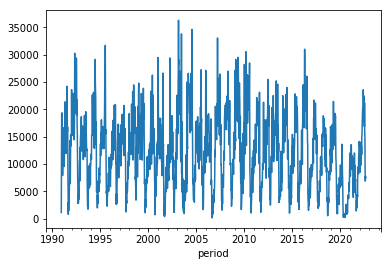

In [11]:
sorted_data['inc'].plot()

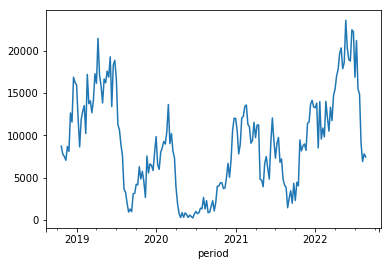

In [12]:
sorted_data['inc'][-200:].plot() 

# Etude de l'incidence annuelle

On décide, dans le cadre de notre exercice, de choisir le 1er septembre comme début de chaque période annuelle.

In [15]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991, sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. 

Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [14]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1], first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles.

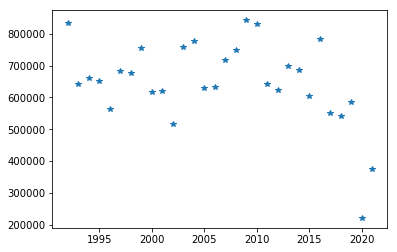

In [16]:
yearly_incidence.plot(style='*') 

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [17]:
yearly_incidence.sort_values() 

2020    221186
2021    376290
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64